In [136]:
import pandas as pd
import datetime as dt
import math
from garmin_fit_sdk import Decoder,Stream
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap
import numpy as np

In [137]:
# read fitdata
def return_ridedata(filename):
    stream = Stream.from_file(filename)
    decoder  = Decoder(stream)
    messages,error = decoder.read()
    ride_data = pd.DataFrame(messages['record_mesgs'])
    
    ride_data['speed'] = ride_data['speed']*3600/1000
    ride_data['position_lat'] = ride_data['position_lat']/(2**31)*180
    ride_data['position_long'] = ride_data['position_long']/(2**31)*180

    target_df = ride_data.loc[ride_data['power']>0]
    target_df['torque'] = target_df['power'] / target_df['cadence'] / 0.105
    ride_data = pd.merge(ride_data,target_df[['timestamp','torque']],on='timestamp',how='left')

    return ride_data


In [138]:
def plot_map(ride_data):
    # 経度
    max_lat = ride_data['position_lat'].max()
    min_lat = ride_data['position_lat'].min()
    point_lat = ride_data['position_lat'].median()
    # 緯度
    max_long = ride_data['position_long'].max()
    min_long = ride_data['position_long'].min()
    point_long = ride_data['position_long'].median()

    # define zomm_start value
    zoom_value = (max_lat - min_lat) * 225
    
    # plot map and add heatmap
    map = folium.Map(location=[point_lat,point_long],zoom_start=zoom_value)
    geovalues = ride_data.dropna(subset='position_lat')
    geovalues = geovalues[['position_lat','position_long']].values.tolist()
    HeatMap(geovalues,radius=3,blur=5).add_to(map)
    return map
    

In [139]:
def plot_ride_summary(ride_data,smoothneth_window):

    ride_data_for_ploting = ride_data.copy()
    ride_data_for_ploting[['power','cadence','speed']] = ride_data_for_ploting[['power','cadence','speed']].rolling(window=smoothneth_window).mean()
    ride_data_for_ploting = ride_data_for_ploting[['timestamp','speed','cadence','power','altitude']]
    ride_data_for_ploting = ride_data_for_ploting.fillna(np.nan)
    
    # pltで描写してみる。
    fig = plt.figure(figsize=(10,7))
    ax = fig.subplots()

    x = ride_data_for_ploting.index
    x_range = abs(ride_data['timestamp'].max() - ride_data['timestamp'].min())

    y1 = ride_data_for_ploting[['power','cadence','altitude']]
    ax.set_title('ride summary')
    ax.set_xticks(np.arange(0,x_range.total_seconds(),300))
    ax.plot(x,y1)

    ax_twin = ax.twinx()
    y2 = ride_data_for_ploting['speed']
    ax_twin.plot(x,y2,y2)
    return ax

In [140]:
def plot_watt_torque_summary(ride_data,smoothneth_window,ftp):
    target_df = ride_data.fillna(np.nan)
    target_df['torque'] = target_df['power'] / target_df['cadence'] / 0.105
    target_df[['power','torque']] = target_df[['power','torque']].rolling(window=smoothneth_window).mean()
    target_df['ftp'] = ftp
    ax = target_df[['timestamp','power','torque','ftp']].round().plot(kind='line',x='timestamp',secondary_y='torque',figsize=(10,7))
    return ax

In [141]:
def calc_training_indicator(ride_data,ftp):
    # NP計算
    # ride_data['power']を30秒ごとに切り分けて、平均を算出する。
    np_df = ride_data[['timestamp','power']]
    np_df['power'] = np_df['power'].fillna(0)
    cut_time = 30
    np_df_index_max = np_df.index.max() / cut_time
    np_index_range = round(np_df_index_max)
    np_index_range

    table = pd.DataFrame(columns=['start_time','end_time','30smean_power'])
    for i in range(np_index_range):
        start_index = range(np_index_range)[i]*30
        end_index = start_index+30
        tmp = np_df.iloc[start_index:end_index]
        mean_power_in_tmp = tmp['power'].mean()
        start_time = tmp['timestamp'].dt.time.min()
        end_time = tmp['timestamp'].dt.time.max()
        tmp_table = pd.DataFrame(columns=['start_time','end_time','30smean_power'])
        tmp_table.loc[0,'start_time'] = start_time
        tmp_table.loc[0,'end_time'] = end_time
        tmp_table.loc[0,'30smean_power'] = mean_power_in_tmp
        table = pd.concat([table,tmp_table],axis=0)

    table['30smean**4'] = table['30smean_power']**4

    np = table['30smean**4'].mean()
    np = math.pow(np,1/4)
    np = round(np,ndigits=2)
    
    # calc Intensity Factor
    intensity_factor = round(np/ ftp,ndigits=2)

    # calc Training stress score
    # TSS =((T * NP * IF) / FTP ) * 100

    duration = (ride_data['timestamp'].max()-ride_data['timestamp'].min())
    seconds = duration.seconds
    times = seconds/60/60
    tss = ((times * np * intensity_factor) / ftp) * 100
    tss = round(tss,ndigits=2)

    indicators = {
        'NP':np,
        'IF':intensity_factor,
        'TSS':tss,
    }
    return indicators

In [142]:
def power_zone_mapping(ride_data,ftp):

    powergroup_10w = ride_data['power'].round(-1).value_counts()
    powergroup_10w = pd.DataFrame(powergroup_10w).sort_index().reset_index()
    powergroup_10w = powergroup_10w.rename(columns={'count':'seconds'})

    l1 = [0,ftp*0.55]
    l2 = [ftp*0.56,ftp**0.75]
    l3 = [ftp*0.76,ftp*0.90]
    l4 = [ftp*0.91,ftp*1.05]
    l5 = [ftp*1.06,ftp*1.2]
    l6 = [ftp*1.21,ftp*1.5]
    l7 = [ftp*1.51,9999]
    zones = {
        'L1':l1,
        'L2':l2,
        'L3':l3,
        'L4':l4,
        'L5':l5,
        'L6':l6,
        'L7':l7,
    }

    power_labeling_data = pd.DataFrame(ride_data[['timestamp','power']])
    tmpzones = pd.DataFrame(columns=['timestamp','power','zone'])
    for key,value in zones.items():
        tmp = power_labeling_data.loc[(power_labeling_data['power']>= value[0])&(power_labeling_data['power']<=value[1])]
        tmp['zone'] = key
        tmpzones = pd.concat([tmpzones,tmp],axis=0)

    power_labeling_data = pd.merge(power_labeling_data,tmpzones[['timestamp','zone']],on='timestamp',how='left')

    tmp = power_labeling_data['zone'].value_counts().reset_index().sort_values(by='zone')
    if set(tmp['zone'].to_list()) ^ set(zones.keys()):
        sabun = set(tmp['zone'].to_list()) ^ set(zones.keys())
        for i in list(sabun):
            tmp2 = pd.DataFrame(columns=['zone','count'])
            tmp2.loc[0,'zone'] = i
            tmp2.loc[0,'count'] = 0
            tmp = pd.concat([tmp,tmp2],axis=0)

    tmp.sort_values(by='zone',inplace=True)

    x = tmp['zone']
    height = tmp['count']

    fig = plt.figure(figsize=(10,7))
    ax = fig.subplots()

    ax.set_title('PowerZones')
    ax.set_xlabel('Zones')
    ax.set_ylabel('seconds')
    figure_zones = ax.bar(x,height,label='seconds')
    ax.legend()
    ax.bar_label(figure_zones,label_type='edge')
    return ax

In [143]:
def plot_watt_torque_curve(ride_data):
    # mmp curveを書くにはどうすればよいか。
    # 計測区間を作る。
    keisoku_list = [10,30,60,180,300,600,1200]

    # 各計測時間でride_dataを区切ったときの最大平均値を求める。
    mmp_table = pd.DataFrame(columns=['seconds','maximum_power','maximum_torque'])
    for s in keisoku_list:
        tmp_table = pd.DataFrame(columns=['seconds','maximum_power','maximum_torque'])
        tmp_table.loc[0,'maximum_power'] = ride_data['power'].rolling(window = s).mean().max()
        tmp_table.loc[0,'maximum_torque'] = ride_data['torque'].rolling(window= s).mean().max()
        tmp_table.loc[0,'seconds'] = s

        mmp_table = pd.concat([mmp_table,tmp_table],axis=0)

    mmp_table = mmp_table.fillna(0)
    
    x = mmp_table['seconds']
    py = mmp_table['maximum_power']
    ty = mmp_table['maximum_torque']

    fig = plt.figure(figsize=(10,7))
    ax = fig.subplots()
    twin = ax.twinx()

    ax.set_title('Watts Torque Curve')
    ax.set_xlabel('seconds')
    ax.set_ylabel('watts')
    ax.grid()
    ax.set_xticks(keisoku_list)
    ax.plot(x,py)

    twin.set_ylabel('torque(N/m)')
    twin.plot(x,ty,color='red')

    for t in range(len(keisoku_list)):
        twin.text(keisoku_list[t],ty.iloc[t],f'{ty.iloc[t].round(2)}N/m')
        ax.text(keisoku_list[t],py.iloc[t],f'{py.iloc[t].round(2)}w')

    return ax

/tmp/ipykernel_5662/4059307111.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_df['torque'] = target_df['power'] / target_df['cadence'] / 0.105
/tmp/ipykernel_5662/1668266461.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp['zone'] = key
/tmp/ipykernel_5662/1668266461.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

{'NP': 216.91, 'IF': 0.99, 'TSS': 89.2}


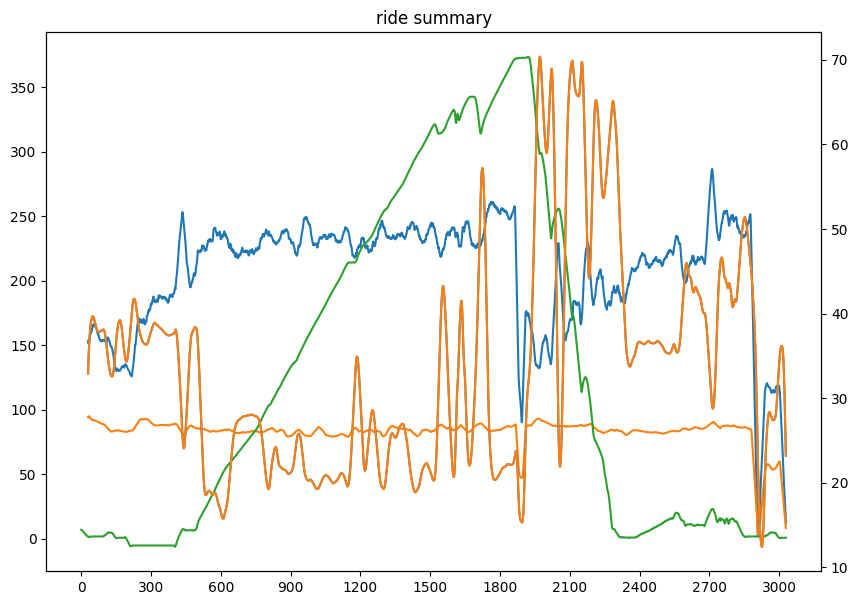

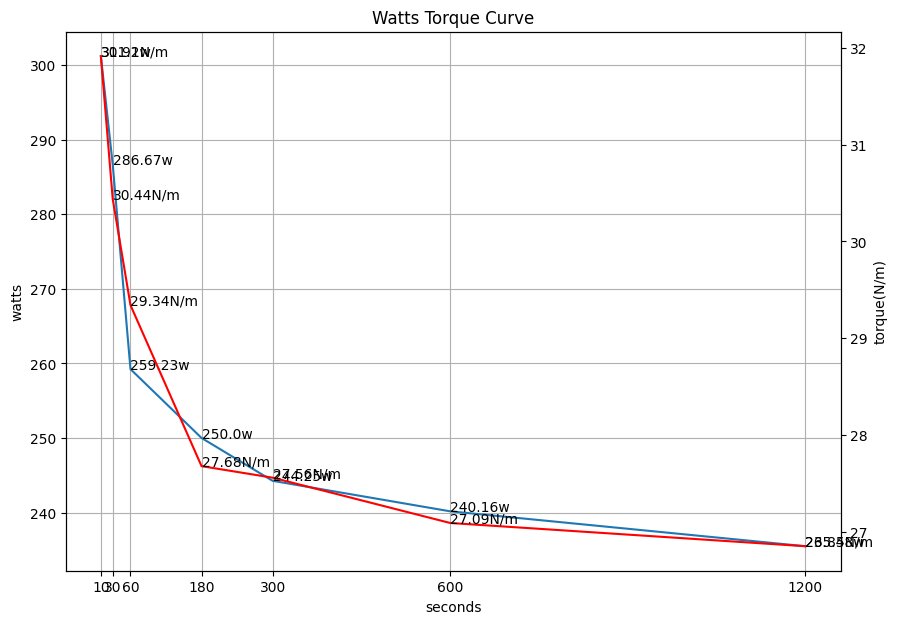

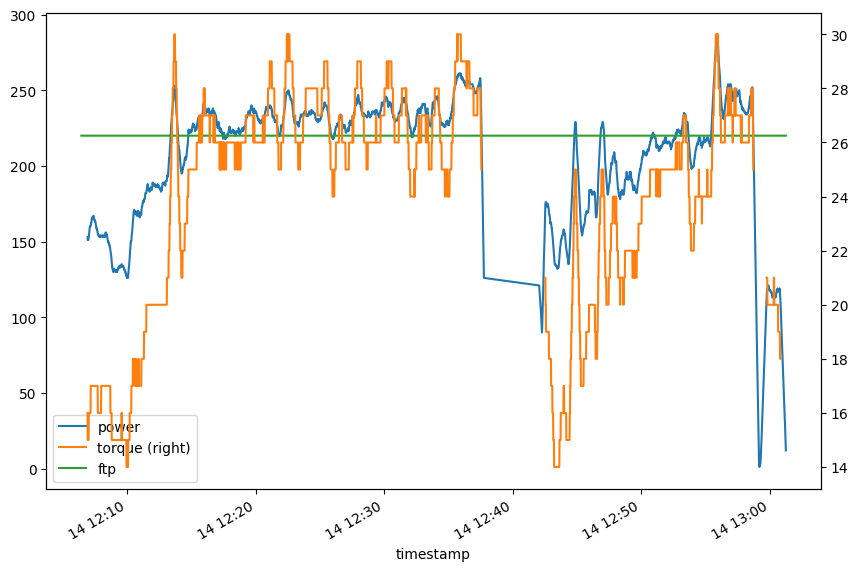

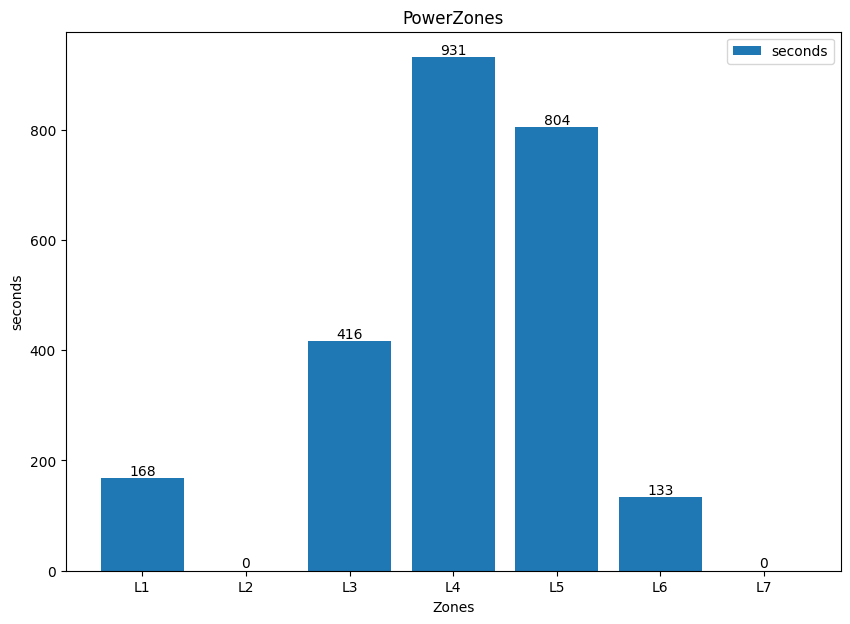

In [144]:
#ride_data = return_ridedata('')
#map = plot_map(ride_data=ride_data)
#ax1 = plot_ride_summary(ride_data=ride_data,smoothneth_window=30)
#ax2 = plot_watt_torque_curve(ride_data=ride_data)
#ax3 = plot_watt_torque_summary(ride_data=ride_data,smoothneth_window=30,ftp=220)
#ax4 = power_zone_mapping(ride_data=ride_data,ftp=220)
#indicator = calc_training_indicator(ride_data=ride_data,ftp=220)

#map.render()
#ax1
#ax2
#ax3
#ax4
#print(indicator)
